In [15]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import random

In [2]:
# Importing birth rate data
birthData = pd.read_csv("Datasets/Birth_Rate_clean.csv")
birthData.tail()

,Data Series,2022 Dec,2022 Nov,2022 Oct,2022 Sep,2022 Aug,2022 Jul,2022 Jun,2022 May,2022 Apr,...,1960 Oct,1960 Sep,1960 Aug,1960 Jul,1960 Jun,1960 May,1960 Apr,1960 Mar,1960 Feb,1960 Jan
10,Total Female Live-Births By Ethnic Group,1422,1452,1506,1539,1458,1426,1379,1420,1306,...,2754,2478,2583,2547,2451,2586,2388,2396,2166,2360
11,Malays,308,323,333,363,319,287,330,320,331,...,474,441,472,426,413,432,393,418,402,394
12,Chinese,825,797,856,869,799,831,748,831,705,...,2013,1754,1856,1848,1794,1910,1776,1756,1523,1701
13,Indians,158,182,161,163,150,173,155,142,154,...,218,243,200,218,210,196,179,178,192,227
14,Other Ethnic Groups,131,150,156,144,190,135,146,127,116,...,49,40,55,55,34,48,40,44,49,38


In [3]:
# Data cleaning
# Update index name
birthData = birthData.rename(columns = {'Data Series':'Date'})
birthData.set_index('Date',inplace=True)
birthData = birthData.rename(columns=lambda x: x.strip())
birthData.columns = pd.DatetimeIndex(birthData.columns).to_period('M')
# birthData.head()

# Switch rows and columns (Tranpose)
birthData = birthData.T
birthData = birthData.rename(columns=lambda x: x.strip())
birthData = birthData.sort_index()
birthData.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 756 entries, 1960-01 to 2022-12
Freq: M
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   Total Live-Births By Ethnic Group         756 non-null    int64
 1   Malays                                    756 non-null    int64
 2   Chinese                                   756 non-null    int64
 3   Indians                                   756 non-null    int64
 4   Other Ethnic Groups                       756 non-null    int64
 5   Total Male Live-Births By Ethnic Group    756 non-null    int64
 6   Malays                                    756 non-null    int64
 7   Chinese                                   756 non-null    int64
 8   Indians                                   756 non-null    int64
 9   Other Ethnic Groups                       756 non-null    int64
 10  Total Female Live-Births By Ethnic Group  7

In [4]:
babies = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])

babies = babies.astype('int64')
babies.head()

,Total Live-Births By Ethnic Group
1960-01,4981
1960-02,4596
1960-03,4964
1960-04,4904
1960-05,5244


## Variable: Marriage Count
- Only annual dataset available
- Looking for ways to split data into monthly
- Found a breakdown of marriages by month made for the year 2018

![Marriage Distribution](Images/Monthly%20Marriages.png)

- Decided to use this to breakdown annual to monthly
    - Assumes that distribution for other years do not differ too much
    - Does not take into account other factors like COVID-19

<AxesSubplot:>

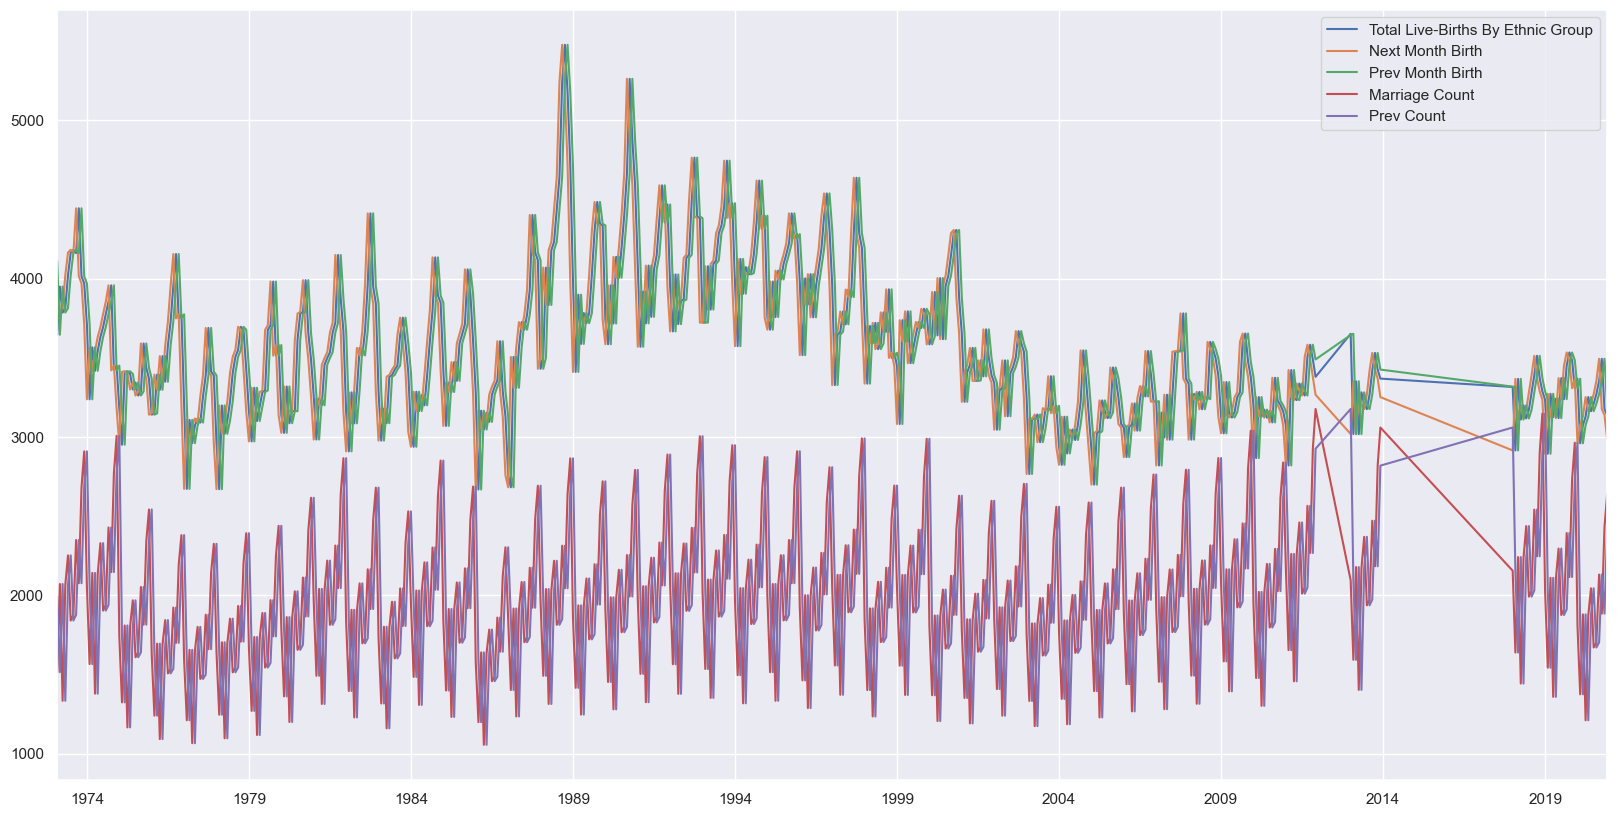

In [5]:
# Reading & Cleaning Total Marriage data
marriageCount = pd.read_csv("Datasets/Marriage_clean.csv")
marriageCount = marriageCount.rename(columns = {'Data Series':'Date'})
marriageCount.set_index('Date',inplace=True)
marriageCount.columns = pd.DatetimeIndex(marriageCount.columns).to_period('M')
marriageCount = marriageCount.T
marriageCount = marriageCount.rename(columns=lambda x: x.strip()).sort_index()
totalMarriage = marriageCount.rename(columns = {'Total Marriages (Number)':'Total Marriages'}).astype({'Total Marriages':'int'})[['Total Marriages']]
# totalMarriage.tail()

# Removing Outliers
Q3 = totalMarriage['Total Marriages'].quantile(0.25)
Q1 = totalMarriage['Total Marriages'].quantile(0.75)
IQR = Q1-Q3
totalMarriage = totalMarriage[~((totalMarriage['Total Marriages'] < (Q1 - 1.5*IQR)) | (totalMarriage['Total Marriages'] > (Q3 + 1.5*IQR)))]

# Monthly Marriage Rate Calculation
monthlyRate = [1963, 1492, 2041, 1314, 2034, 2220, 1814, 1849, 2315, 2046, 2641, 2867]
sumOfMonthly = sum(monthlyRate)
monthlyRate = [x/sumOfMonthly for x in monthlyRate]

# Breaking down annual to monthly
marriageSplit = pd.DataFrame(columns=['Date', 'Marriage Count']).astype({'Marriage Count':'int'})
for index, row in totalMarriage.iterrows():
    date = index
    total = row['Total Marriages']
    for i in range(12):
        marriageSplit = pd.concat([marriageSplit, pd.DataFrame({'Date':[date + pd.offsets.MonthEnd(i)], 'Marriage Count':[(int)(total*monthlyRate[i])]})])
marriageSplit.set_index('Date',inplace=True)

# Copy of Birth Data
marriageBaby = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])
marriageBaby['Next Month Birth'] = marriageBaby['Total Live-Births By Ethnic Group'].shift(-1)
marriageBaby['Prev Month Birth'] = marriageBaby['Total Live-Births By Ethnic Group'].shift(1)

marriageSplit = pd.concat([marriageBaby, marriageSplit], axis=1, join='inner')
marriageSplit['Prev Count'] = marriageSplit['Marriage Count'].shift(1)

# Remove NaN rows
marriageSplit = marriageSplit.dropna()

marriageSplit.plot(figsize=(20, 10))

In [6]:
marriageSplit.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 515 entries, 1973-02 to 2020-12
Freq: M
Data columns (total 5 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Total Live-Births By Ethnic Group  515 non-null    int64  
 1   Next Month Birth                   515 non-null    float64
 2   Prev Month Birth                   515 non-null    float64
 3   Marriage Count                     515 non-null    int64  
 4   Prev Count                         515 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 24.1 KB


In [7]:
marriageSplit.corr()

,Total Live-Births By Ethnic Group,Next Month Birth,Prev Month Birth,Marriage Count,Prev Count
Total Live-Births By Ethnic Group,1.000000,0.847115,0.846104,0.374054,0.143469
Next Month Birth,0.847115,1.000000,0.738163,0.133795,-0.040040
Prev Month Birth,0.846104,0.738163,1.000000,0.341003,0.380257
Marriage Count,0.374054,0.133795,0.341003,1.000000,0.303609
Prev Count,0.143469,-0.040040,0.380257,0.303609,1.000000


## Analysis
- Compared to the [housing resale analysis](Housing%20Prices%20Analysis.ipynb), there is more data points available (about 200 more)
- Decided to remove outliers at the annual stage, since there are assumptions made in the monthly one
    - Rather remove outliers from actual data first
- Resulting correlation is very weak

## Classification: Random Forest vs Logistic Regression
- Goal: From the available variables this month, predict the rise/fall of the next month's birth rate
- Available Data:
    - Current/Prev Month Birth Count
    - Current/Prev Month Marriage Count
    
## Performance Evaluation Technique: K-Fold vs Leave-One-Out
- Leave-one-out too computational expensive, going for K-Fold instead
- Since dataset is small (About 500+ data points), use a smaller fold number (5)
- This gives about 100+ data points for each fold

## Classification Model Performance Metrics
- Accuracy:  Number of correct predictions
- Precision: Proportion of true positives out of all positive predictions
- Recall:    Proportion of true positives out of all actual positive cases
- F1 Score:  Harmonic mean of precision and recall

In [8]:
# Step 1: Create binary target variable
marriageSplit['Rise-Fall'] = (marriageSplit['Total Live-Births By Ethnic Group'] > marriageSplit['Next Month Birth']).astype(int)

In [9]:
resultsRf = []

for i in range(100):
    # Defining number of folds for cross-validation
    num_folds = 5
    
    # Defining random seed
    seed = random.randint(0, 100000)
       
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = marriageSplit[['Total Live-Births By Ethnic Group', 'Prev Month Birth', 'Marriage Count', 'Prev Count']]

    # Step 2.2: Response
    y = marriageSplit['Rise-Fall']
    
    # Step 3: Creating KFold
    kResRf = []
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Step 4: Loop over folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Step 4.1: Split data into training and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Step 4.2: Creating Random Forest and Logistic Regression Classifier
        rf = RandomForestClassifier(max_depth=10)
        
        # Step 4.3: Fit model to training data
        rf.fit(X_train, y_train)
        
        # Step 4.4: Make predictions on test data
        y_pred_rf = rf.predict(X_test)
        
        # Step 4.5: Evalute performance
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        precision_rf = precision_score(y_test, y_pred_rf)
        recall_rf = recall_score(y_test, y_pred_rf)
        f1_rf = f1_score(y_test, y_pred_rf)
        
        kResRf.append((fold, accuracy_rf, precision_rf, recall_rf, f1_rf))
        
    # Step 6: Compute the mean and standard deviation of the performance metrics across all folds
    acc_mean_rf, acc_std_rf = np.mean([r[1] for r in kResRf]), np.std([r[1] for r in kResRf])
    prec_mean_rf, prec_std_rf = np.mean([r[2] for r in kResRf]), np.std([r[2] for r in kResRf])
    rec_mean_rf, rec_std_rf = np.mean([r[3] for r in kResRf]), np.std([r[3] for r in kResRf])
    f1_mean_rf, f1_std_rf = np.mean([r[4] for r in kResRf]), np.std([r[4] for r in kResRf])
    
    resultsRf.append((seed, acc_mean_rf, acc_std_rf, prec_mean_rf, prec_std_rf, rec_mean_rf, rec_std_rf, f1_mean_rf, f1_std_rf))
    
#     # Step 3: Split data into training and test sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Sort results by F1 score in descending order
resultsRf.sort(key=lambda x: x[7], reverse=True)

In [10]:
resultsLr = []

for i in range(5):
    seed = resultsRf[i][0]
    kResLr = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        lr = LogisticRegression(max_iter=1000, solver='liblinear')
        lr.fit(X_train, y_train)
        y_pred_lr = lr.predict(X_test)
        
        accuracy_lr = accuracy_score(y_test, y_pred_lr)
        precision_lr = precision_score(y_test, y_pred_lr)
        recall_lr = recall_score(y_test, y_pred_lr)
        f1_lr = f1_score(y_test, y_pred_lr)
        kResLr.append((fold, accuracy_lr, precision_lr, recall_lr, f1_lr))
        
    acc_mean_lr, acc_std_lr = np.mean([r[1] for r in kResLr]), np.std([r[1] for r in kResLr])
    prec_mean_lr, prec_std_lr = np.mean([r[2] for r in kResLr]), np.std([r[2] for r in kResLr])
    rec_mean_lr, rec_std_lr = np.mean([r[3] for r in kResLr]), np.std([r[3] for r in kResLr])
    f1_mean_lr, f1_std_lr = np.mean([r[4] for r in kResLr]), np.std([r[4] for r in kResLr])   
    resultsLr.append((seed, acc_mean_lr, acc_std_lr, prec_mean_lr, prec_std_lr, rec_mean_lr, rec_std_lr, f1_mean_lr, f1_std_lr))

In [11]:
topResultsRf = resultsRf[:5]

for i in range(5):
    print('----------------------------------------------')
    print(f"Random state {topResultsRf[i][0]}:")
    print(f'Accuracy  = {topResultsRf[i][1]:.4f} +/- {topResultsRf[i][2]:.4f}  vs  {resultsLr[i][1]:.4f} +/- {resultsLr[i][2]:.4f}')
    print(f'Precision = {topResultsRf[i][3]:.4f} +/- {topResultsRf[i][4]:.4f}  vs  {resultsLr[i][3]:.4f} +/- {resultsLr[i][4]:.4f}')
    print(f'Recall    = {topResultsRf[i][5]:.4f} +/- {topResultsRf[i][6]:.4f}  vs  {resultsLr[i][5]:.4f} +/- {resultsLr[i][6]:.4f}')
    print(f'F1 score  = {topResultsRf[i][7]:.4f} +/- {topResultsRf[i][8]:.4f}  vs  {resultsLr[i][7]:.4f} +/- {resultsLr[i][8]:.4f}')
print('----------------------------------------------')

----------------------------------------------
Random state 78845:
Accuracy  = 0.8058 +/- 0.0325  vs  0.6641 +/- 0.0235
Precision = 0.7933 +/- 0.0301  vs  0.6545 +/- 0.0550
Recall    = 0.7958 +/- 0.0488  vs  0.6171 +/- 0.0858
F1 score  = 0.7934 +/- 0.0267  vs  0.6287 +/- 0.0332
----------------------------------------------
Random state 53681:
Accuracy  = 0.8058 +/- 0.0137  vs  0.6641 +/- 0.0235
Precision = 0.7915 +/- 0.0446  vs  0.6545 +/- 0.0550
Recall    = 0.8002 +/- 0.0572  vs  0.6171 +/- 0.0858
F1 score  = 0.7930 +/- 0.0159  vs  0.6287 +/- 0.0332
----------------------------------------------
Random state 1745:
Accuracy  = 0.8058 +/- 0.0539  vs  0.6641 +/- 0.0235
Precision = 0.7928 +/- 0.1038  vs  0.6545 +/- 0.0550
Recall    = 0.7969 +/- 0.0416  vs  0.6171 +/- 0.0858
F1 score  = 0.7917 +/- 0.0655  vs  0.6287 +/- 0.0332
----------------------------------------------
Random state 56463:
Accuracy  = 0.8019 +/- 0.0250  vs  0.6641 +/- 0.0235
Precision = 0.7846 +/- 0.0640  vs  0.6545 +/

## Logistic Regression vs Random Forest
The random forest model has done significantly better than logistic regression, despite using the same seed

Conclusion: Random forest is the better model, no doubts about it

In [12]:
resultsRf2 = []

for i in range(5):
    seed = resultsRf[i][0]
       
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = marriageSplit[['Total Live-Births By Ethnic Group', 'Prev Month Birth', 'Marriage Count']]

    # Step 2.2: Response
    y = marriageSplit['Rise-Fall']
    
    # Step 3: Creating KFold
    kResRf = []
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Step 4: Loop over folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Step 4.1: Split data into training and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Step 4.2: Creating Random Forest and Logistic Regression Classifier
        rf = RandomForestClassifier(max_depth=10)
        
        # Step 4.3: Fit model to training data
        rf.fit(X_train, y_train)
        
        # Step 4.4: Make predictions on test data
        y_pred_rf = rf.predict(X_test)
        
        # Step 4.5: Evalute performance
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        precision_rf = precision_score(y_test, y_pred_rf)
        recall_rf = recall_score(y_test, y_pred_rf)
        f1_rf = f1_score(y_test, y_pred_rf)
        
        kResRf.append((fold, accuracy_rf, precision_rf, recall_rf, f1_rf))
        
    # Step 6: Compute the mean and standard deviation of the performance metrics across all folds
    acc_mean_rf, acc_std_rf = np.mean([r[1] for r in kResRf]), np.std([r[1] for r in kResRf])
    prec_mean_rf, prec_std_rf = np.mean([r[2] for r in kResRf]), np.std([r[2] for r in kResRf])
    rec_mean_rf, rec_std_rf = np.mean([r[3] for r in kResRf]), np.std([r[3] for r in kResRf])
    f1_mean_rf, f1_std_rf = np.mean([r[4] for r in kResRf]), np.std([r[4] for r in kResRf])
    
    resultsRf2.append((seed, acc_mean_rf, acc_std_rf, prec_mean_rf, prec_std_rf, rec_mean_rf, rec_std_rf, f1_mean_rf, f1_std_rf))

In [13]:
print(f'Average Accuracy:  {sum([i[1] for i in topResultsRf])/5:.4f}  \
      vs  {sum([i[1] for i in resultsRf2])/5:.4f}')
print(f'Average Precision: {sum([i[3] for i in topResultsRf])/5:.4f}  \
      vs  {sum([i[3] for i in resultsRf2])/5:.4f}')
print(f'Average Recall:    {sum([i[5] for i in topResultsRf])/5:.4f}  \
      vs  {sum([i[5] for i in resultsRf2])/5:.4f}')
print(f'Average F1 Score:  {sum([i[7] for i in topResultsRf])/5:.4f}  \
      vs  {sum([i[7] for i in resultsRf2])/5:.4f}')

Average Accuracy:  0.8043        vs  0.6784
Average Precision: 0.7908        vs  0.6543
Average Recall:    0.7955        vs  0.6742
Average F1 Score:  0.7907        vs  0.6599


## Final Verdict on Variables
In this case, unlike the housing resale dataset, the addition of the previous month's marriage data gives a better model

Conclusion: Include the previous month's marriage data

## Bagging Classifier vs Top Model from Random Forest
- Multiple models were trained previously
- Retrain the Random Forest models with the seeds used, but with the entire dataset rather than the K-Fold ones
- Trying out another model which combines the top models trained from the Random Forest (Bagging Classifier)
- Comparing to see if it will give a better model

In [25]:
results = []

for i in range(5):
    seed = resultsRf[i][0]
       
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = marriageSplit[['Total Live-Births By Ethnic Group', 'Prev Month Birth', 'Marriage Count', 'Prev Count']]

    # Step 2.2: Response
    y = marriageSplit['Rise-Fall']
    
    # step 3: Spit data into training and test sets    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # Step 4: Creating Random Forest Classifier object
    rf = RandomForestClassifier(max_depth=10)
    
    # Step 5: Fit model to training set
    rf.fit(X_train, y_train)
    
    # Step 6: Make predictions on test set
    y_pred = rf.predict(X_test)
    
    # Step 7: Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append((seed, accuracy, precision, recall, f1, rf))

In [26]:
bagRes = []

for i in range(5):
    seed = resultsRf[i][0]
    
    finalModels = [res[-1] for res in results]
    bc = BaggingClassifier(n_estimators=len(finalModels))

    bc.estimators_ = finalModels

    X = marriageSplit[['Total Live-Births By Ethnic Group', 'Prev Month Birth', 'Marriage Count', 'Prev Count']]
    y = marriageSplit['Rise-Fall']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    bc.fit(X_train, y_train)

    y_pred = bc.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    bagRes.append((seed, accuracy, precision, recall, f1, bc))

In [27]:
for i in range(5):
    print('----------------------------------------------')
    print(f"Random state {resultsRf[i][0]}:")
    print(f'Accuracy  = {results[i][1]:.4f}  vs  {bagRes[i][1]:.4f}')
    print(f'Precision = {results[i][2]:.4f}  vs  {bagRes[i][2]:.4f}')
    print(f'Recall    = {results[i][3]:.4f}  vs  {bagRes[i][3]:.4f}')
    print(f'F1 score  = {results[i][4]:.4f}  vs  {bagRes[i][4]:.4f}')
print('----------------------------------------------')

----------------------------------------------
Random state 78845:
Accuracy  = 0.7573  vs  0.7184
Precision = 0.7826  vs  0.7292
Recall    = 0.7059  vs  0.6863
F1 score  = 0.7423  vs  0.7071
----------------------------------------------
Random state 53681:
Accuracy  = 0.8155  vs  0.7767
Precision = 0.7647  vs  0.7255
Recall    = 0.8478  vs  0.8043
F1 score  = 0.8041  vs  0.7629
----------------------------------------------
Random state 1745:
Accuracy  = 0.8058  vs  0.7864
Precision = 0.7778  vs  0.7692
Recall    = 0.8400  vs  0.8000
F1 score  = 0.8077  vs  0.7843
----------------------------------------------
Random state 56463:
Accuracy  = 0.8350  vs  0.8155
Precision = 0.8800  vs  0.8462
Recall    = 0.8000  vs  0.8000
F1 score  = 0.8381  vs  0.8224
----------------------------------------------
Random state 18363:
Accuracy  = 0.8252  vs  0.7767
Precision = 0.8113  vs  0.7593
Recall    = 0.8431  vs  0.8039
F1 score  = 0.8269  vs  0.7810
----------------------------------------------

The `Random Forest Classifier` model has been constantly doing better than the `Bagging Classifier`

Conclusion: `Random Forest Classifier`

## Final Conclusion
- Model: Random Forest Classifier
- Variables: Current and Previous Month Marriage Count